In [1]:
import adi
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.fft as fft
import scipy.signal as sig
from scipy.signal import hann
from pandas import read_csv, DataFrame
import matplotlib as mpl
import functools
from timeit import default_timer as timer
%matplotlib inline

In [2]:
golden_ratio = (np.sqrt(5) - 1) / 2
width = 6.9
height = width * golden_ratio

In [3]:
# Real
lattice_center = 5 # in length domain, micrometers
lattice_center_freq = 5e6 # Hz
lattice_step = 5 # micrometers
alpha = 0.2e6

signal_amplitude = 2**14
laser_switching_time = 50e-6
laser_switching_speed = signal_amplitude / laser_switching_time
atom_speed = 0.0175e12 # in frequency domain, Hz/s

sample_rate = int(16e6)
buff_size = int(2**13)
lo = int(99e6)

# # Testing
# lattice_center = 5 # in length domain, micrometers
# lattice_center_freq = 5e6 # Hz
# lattice_step = 5 # micrometers
# alpha = 0.2e6

# signal_amplitude = 2**14
# laser_switching_time = 50e-4
# laser_switching_speed = signal_amplitude / laser_switching_time
# atom_speed = 0.0175e10 # in frequency domain, Hz/s

# sample_rate = int(16e6)
# buff_size = int(2**19)
# lo = int(99e6)


# lattice_center_x = 5 # in length domain, micrometers
# lattice_center_y = 5 # in length domain, micrometers
# lattice_center_freq_x = 5 # Hz
# lattice_center_freq_y = 5 # Hz
# lattice_step = 5 # micrometers
# alpha_x = 1
# alpha_y = 1

# signal_amplitude = 1
# laser_switching_time = 1
# laser_switching_speed = signal_amplitude / laser_switching_time
# atom_speed = 1 # in frequency domain, Hz/s

In [4]:
# def coord_to_freq(i, direction): # direction = True for X
#     # см. #вычисление угла на стр. 1
#     if direction:
#         return lattice_center_freq_x + alpha_x * (i * lattice_step - lattice_center_x)
#     else:
#         return lattice_center_freq_y + alpha_y * (i * lattice_step - lattice_center_y)
    
def coord_to_freq(i, direction): # direction = True for X
    # см. #вычисление угла на стр. 1
    x_freqs = np.array([int(101.6e6), int(100.7e6),  int(99.7e6),  int(98.8e6),  int(97.9e6)]) - lo
    y_freqs = np.array([ int(97.3e6),  int(98.1e6),  int(99.1e6),  int(100.1e6), int(100.9e6)]) - lo
    if direction:
        return x_freqs[i]
    else:
        return y_freqs[i]

# def coord_to_freq(i, direction): # direction = True for X
#     # см. #вычисление угла на стр. 1
#     x_freqs = np.array([int(101.6e6), int(100.7e6),  int(99.7e6),  int(98.8e6),  int(97.9e6)])
#     y_freqs = np.array([ int(97.3e6),  int(98.1e6),  int(99.1e6),  int(100.1e6), int(100.9e6)])
#     if direction:
#         return x_freqs[i]
#     else:
#         return y_freqs[i]

In [5]:
def atom_signal(start_freq, end_freq):
    def harmonic(t):
        freq_sign = 1 if end_freq > start_freq else -1
    #     print(laser_switching_time + freq_sign * (end_freq - start_freq)  / atom_speed)
        if t < laser_switching_time:
    #         print("turn on")
            return laser_switching_speed * t * np.exp(2j*np.pi * start_freq * t)
        elif t < laser_switching_time + freq_sign * (end_freq - start_freq)  / atom_speed:
            local_t = t - laser_switching_time
    #         print("move", start_freq + freq_sign * atom_speed * local_t)
            return signal_amplitude * np.exp(2j*np.pi *(start_freq + freq_sign * atom_speed * local_t) * t)
        elif t < laser_switching_time * 2 + freq_sign * (end_freq - start_freq)  / atom_speed:
            local_t = t - laser_switching_time - freq_sign * (end_freq - start_freq)  / atom_speed
    #         print("turn off", local_t)
            return (signal_amplitude - laser_switching_speed * local_t) * np.exp(2j*np.pi * end_freq * t)
        else:
    #         print("off")
            return 0
    return harmonic

def transition_time(start_freq, end_freq):
    return laser_switching_time * 2 + abs(end_freq - start_freq)  / atom_speed

def generate_main_signal(direction, input_array, output_array):
    # Эта переменная нужна для вычисления времени, которое необходимо для движения
    transition_time_max = 0
    
    # Формирование движений из списков атомов
    frequencies = []
    i = 0
    j = 0
    while i < len(input_array) and j < len(output_array):
        if input_array[i] == 1:
            if output_array[j] == 1:
                start_freq = coord_to_freq(i, direction)
                end_freq = coord_to_freq(j, direction)
                frequencies.append((start_freq, end_freq))
                i = i + 1
                j = j + 1

                time = transition_time(start_freq, end_freq)
                if transition_time_max > time:
                    transition_time_max = time
            else:
                j = j + 1
        else:
            i = i + 1

    signals = []
    for start_freq, end_freq in frequencies:
        # print("start & end freqs", start_freq, end_freq)
        # print("transition time", tansition_time(start_freq, end_freq)*1e6, "us")
        signals.append(atom_signal(start_freq, end_freq))
#     return np.vectorize(lambda t: functools.reduce(lambda acc, harmonic: acc + harmonic(t), signals,0) / len(signals))
    return np.vectorize(lambda t: functools.reduce(lambda acc, harmonic: acc + harmonic(t), signals,0))

def generate_static_signal(coord, direction):
    freq = coord_to_freq(coord, direction)
    def harmonic(t):
            return signal_amplitude * np.exp(2j*np.pi * freq * t)
    return np.vectorize(lambda t: harmonic(t))

def generate_signal_bundle(direction, coord, input_array, output_array):
    if direction:
        x_signal = generate_main_signal(direction, input_array, output_array)
        y_signal = generate_static_signal(coord, not direction)
    else:
        y_signal = generate_main_signal(direction, input_array, output_array)
        x_signal = generate_static_signal(coord, not direction)
    return (x_signal, y_signal)

def send_signal_to_sdr(sdr, x_signal, y_signal):
    N = sdr.tx_buffer_size
    sample_rate = sdr.sample_rate
    times = np.linspace(0, N / sample_rate, N)
    x_dots = x_signal(times)
    y_dots = y_signal(times)
    sdr.tx_destroy_buffer()
    sdr.tx([x_dots, y_dots])

def picture_signal(start_freq, end_freq, time):
    def harmonic(t):
        freq_sign = 1 if end_freq > start_freq else -1
    #     print(laser_switching_time + freq_sign * (end_freq - start_freq)  / atom_speed)
        if time < laser_switching_time:
    #         print("turn on")
            return laser_switching_speed * time * np.exp(2j*np.pi * start_freq * t)
        elif time < laser_switching_time + freq_sign * (end_freq - start_freq)  / atom_speed:
            local_t = time - laser_switching_time
    #         print("move", start_freq + freq_sign * atom_speed * local_t)
            return signal_amplitude * np.exp(2j*np.pi *(start_freq + freq_sign * atom_speed * local_t) * t)
        elif time < laser_switching_time * 2 + freq_sign * (end_freq - start_freq)  / atom_speed:
            local_t = time - laser_switching_time - freq_sign * (end_freq - start_freq)  / atom_speed
    #         print("turn off", local_t)
            return (signal_amplitude - laser_switching_speed * local_t) * np.exp(2j*np.pi * end_freq * t)
        else:
    #         print("off")
            return 0
    return harmonic

def generate_picture_signal(direction, input_array, output_array, time):
    # Формирование движений из списков атомов
    frequencies = []
    i = 0
    j = 0
    while i < len(input_array) and j < len(output_array):
        if input_array[i] == 1:
            if output_array[j] == 1:
                start_freq = coord_to_freq(i, direction)
                end_freq = coord_to_freq(j, direction)
                frequencies.append((start_freq, end_freq))
                i = i + 1
                j = j + 1
            else:
                j = j + 1
        else:
            i = i + 1

    signals = []
    for start_freq, end_freq in frequencies:
        # print("start & end freqs", start_freq, end_freq)
        # print("transition time", tansition_time(start_freq, end_freq)*1e6, "us")
        signals.append(picture_signal(start_freq, end_freq, time))
#     return np.vectorize(lambda t: functools.reduce(lambda acc, harmonic: acc + harmonic(t), signals,0) / len(signals))
    return np.vectorize(lambda t: functools.reduce(lambda acc, harmonic: acc + harmonic(t), signals,0))

def generate_picture_bundle(direction, coord, input_array, output_array, time):
    if direction:
        x_signal = generate_picture_signal(direction, input_array, output_array, time)
        y_signal = generate_static_signal(coord, not direction)
    else:
        y_signal = generate_picture_signal(direction, input_array, output_array, time)
        x_signal = generate_static_signal(coord, not direction)
    return (x_signal, y_signal)

In [6]:
# Тестирование размера буфера
transition_time(coord_to_freq(0, True), coord_to_freq(4, True)) * sample_rate

4982.857142857143

Buffer time: 0.512ms, Transition time: 0.306ms


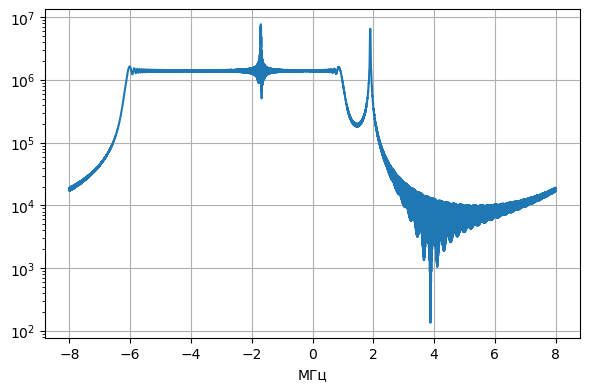

In [7]:
start = 4
stop = 0
direction = False
# sample_rate = int(50e6)
# buff_size = int(2**14)
# lo = int(99e6)
sig = np.vectorize(atom_signal(coord_to_freq(start, direction), coord_to_freq(stop, direction)))
t = np.linspace(0, buff_size / sample_rate, buff_size)
data = sig(t)
print("Buffer time: {:.3f}ms, Transition time: {:.3f}ms".format(buff_size / sample_rate * 1e3, transition_time(coord_to_freq(start, direction), coord_to_freq(stop, direction)) * 1e3))

spectrum = np.abs(fft.fftshift(fft.fft(data)))
frequencies = fft.fftshift(fft.fftfreq(data.shape[0], 1 / sample_rate)) / 1e6

plt.figure(figsize=[width,height])
plt.plot(frequencies, spectrum)
plt.yscale('log')
plt.xlabel("МГц")
# plt.axvline(101492256e-6)
# plt.axvline(97840290e-6)
# plt.xlim(-.5,.5)
plt.grid()
# plt.savefig('../TeX/figures/spectrum/Y_scaled.pdf', bbox_inches='tight')
plt.show()

Buffer time: 0.512ms, Transition time: 0.311ms


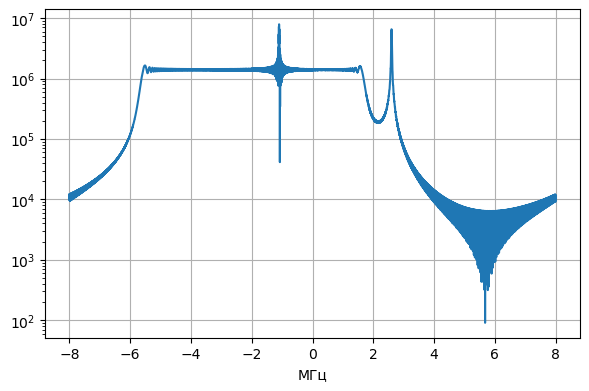

In [8]:
start = 0
stop = 4
direction = True
# sample_rate = int(14e6)
# buff_size = int(2**13)
# lo = int(99e6)

sig = np.vectorize(atom_signal(coord_to_freq(start, direction), coord_to_freq(stop, direction)))
t = np.linspace(0, buff_size / sample_rate, buff_size)
data = sig(t)
print("Buffer time: {:.3f}ms, Transition time: {:.3f}ms".format(buff_size / sample_rate * 1e3, transition_time(coord_to_freq(start, direction), coord_to_freq(stop, direction)) * 1e3))

spectrum = np.abs(fft.fftshift(fft.fft(data)))
frequencies = fft.fftshift(fft.fftfreq(data.shape[0], 1 / sample_rate)) / 1e6

plt.figure(figsize=[width,height])
plt.plot(frequencies, spectrum)
plt.yscale('log')
plt.xlabel("МГц")
# plt.axvline(101492256e-6)
# plt.axvline(97840290e-6)
# plt.xlim(-.5,.5)
plt.grid()
# plt.savefig('../Pres/figures/spectrum/X_scaled.pdf', bbox_inches='tight')
plt.show()

# Работа с железом

In [9]:
sdr = adi.ad9361('ip:172.16.1.246')

In [10]:
sdr.tx_destroy_buffer()
sdr.rx_lo = lo
sdr.tx_lo = lo
sdr.sample_rate = sample_rate
sdr.rx_rf_bandwidth = int(1.6 * sdr.sample_rate / 2)
sdr.tx_rf_bandwidth = int(1.6 * sdr.sample_rate / 2)
sdr.gain_control_mode = "slow_attack"
sdr.tx_hardwaregain = 0
sdr.tx_enabled_channels = [0,1]
sdr.rx_enabled_channels = [0,1]
sdr.tx_buffer_size = buff_size
sdr.rx_buffer_size = buff_size
# Подключение: TX2 - RX1
sdr.tx_destroy_buffer()
sdr.rx_destroy_buffer()
sdr.tx_cyclic_buffer = True
sdr.loopback = 0

In [11]:
# # Тестирование задания координат
i = 4
j = 4
amplitude = 2**14
N = sdr.tx_buffer_size
sample_rate = sdr.sample_rate
times = np.linspace(0, N / sample_rate, N)
print("X:{}, f_x={:.3f}MHz,Y:{},f_y={:.3f}MHz".format(i,coord_to_freq(i,True)*1e-6,j,coord_to_freq(j,False)*1e-6))
x_dots = amplitude * np.exp(2j * np.pi * coord_to_freq(i,True) * times)
y_dots = amplitude * np.exp(2j * np.pi * coord_to_freq(j,False) * times)
sdr.tx_destroy_buffer()
sdr.tx([x_dots, y_dots])

X:4, f_x=-1.100MHz,Y:4,f_y=1.900MHz


In [12]:
# print(

In [13]:
input_array = np.array([1,1,0,0,0])
output_array = np.array([0,0,1,0,1])
coord = 2
direction = True
time = transition_time(coord_to_freq(2, True), coord_to_freq(4, True)) * 0.2
x_signal, y_signal = generate_picture_bundle(direction, coord, input_array, output_array, time)

In [14]:
N = sdr.tx_buffer_size
sample_rate = sdr.sample_rate
times = np.linspace(0, N / sample_rate, N)
x_dots = x_signal(times)
y_dots = y_signal(times)

In [15]:
sdr.tx_destroy_buffer()
sdr.tx([x_dots, y_dots])

In [16]:
np.abs(x_dots).max()

26588.891428571435

# Тестирование спектров

In [17]:
def get_averaged_spectrum(sdr, average=10):
    x_signal, y_signal = sdr.rx()
    x_spectrum = fft.fftshift(fft.fft(x_signal))
    y_spectrum = fft.fftshift(fft.fft(y_signal))
    for i in range(average-1):
        x_signal, y_signal = sdr.rx()
        x_spectrum = x_spectrum + fft.fftshift(fft.fft(x_signal))
        y_spectrum = y_spectrum + fft.fftshift(fft.fft(y_signal))
    x_spectrum = x_spectrum / average
    y_spectrum = y_spectrum / average
    frequencies = fft.fftshift(fft.fftfreq(x_signal.shape[0], 1 / sdr.sample_rate) + sdr.rx_lo) / 1e6
    x_spectrum = DataFrame(data = x_spectrum.imag**2 + x_spectrum.real**2, index = frequencies)
    y_spectrum = DataFrame(data = y_spectrum.imag**2 + y_spectrum.real**2, index = frequencies)
    return (x_spectrum, y_spectrum)

In [18]:
# X
input_array = np.array([1,0,0,0,0])
output_array = np.array([0,0,0,0,1])
coord = 0
direction = True
x_signal, y_signal = generate_signal_bundle(direction, coord, input_array, output_array)

In [19]:
N = sdr.tx_buffer_size
sample_rate = sdr.sample_rate
times = np.linspace(0, N / sample_rate, N)
x_dots = x_signal(times)
y_dots = y_signal(times)

In [20]:
sdr.tx_destroy_buffer()
sdr.tx([x_dots, y_dots])

In [21]:
x_measured_spectrum, y_measured_spectrum = get_averaged_spectrum(sdr, 10)

In [22]:
x_generated_spectrum_ = fft.fftshift(fft.fft(x_dots))
y_generated_spectrum_ = fft.fftshift(fft.fft(y_dots))
frequencies = fft.fftshift(fft.fftfreq(x_dots.shape[0], 1 / sdr.sample_rate) + sdr.rx_lo) / 1e6
x_generated_spectrum = DataFrame(data = x_generated_spectrum_.imag**2 + x_generated_spectrum_.real**2, index = frequencies)
y_generated_spectrum = DataFrame(data = y_generated_spectrum_.imag**2 + y_generated_spectrum_.real**2, index = frequencies)
# generated_spectrum = generated_spectrum / generated_spectrum.max()

In [23]:
x_measured_spectrum_norm = x_measured_spectrum / x_measured_spectrum.mean()
y_measured_spectrum_norm = y_measured_spectrum / y_measured_spectrum.mean()
x_generated_spectrum_norm = x_generated_spectrum / x_generated_spectrum.mean()
y_generated_spectrum_norm = y_generated_spectrum / y_generated_spectrum.mean()

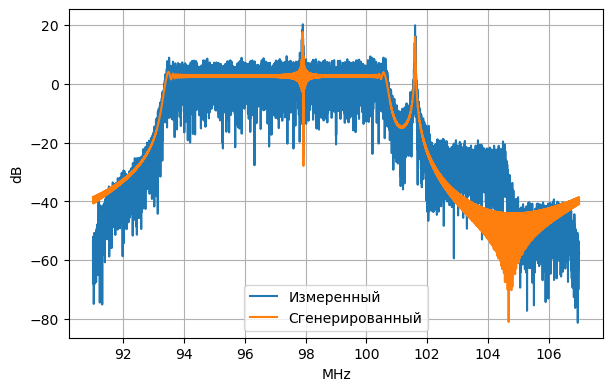

In [24]:
plt.figure(figsize=[width,height])
plt.plot(10*np.log10(x_measured_spectrum_norm), label="Измеренный")
plt.plot(10*np.log10(x_generated_spectrum_norm), label="Сгенерированный")
# plt.yscale('log')
plt.grid()
plt.xlabel("MHz")
plt.ylabel("dB")
plt.legend()
# plt.ylabel("dB")
# plt.savefig('../TeX/figures/spectrum/X_measured_norm.pdf', bbox_inches='tight')
plt.show()

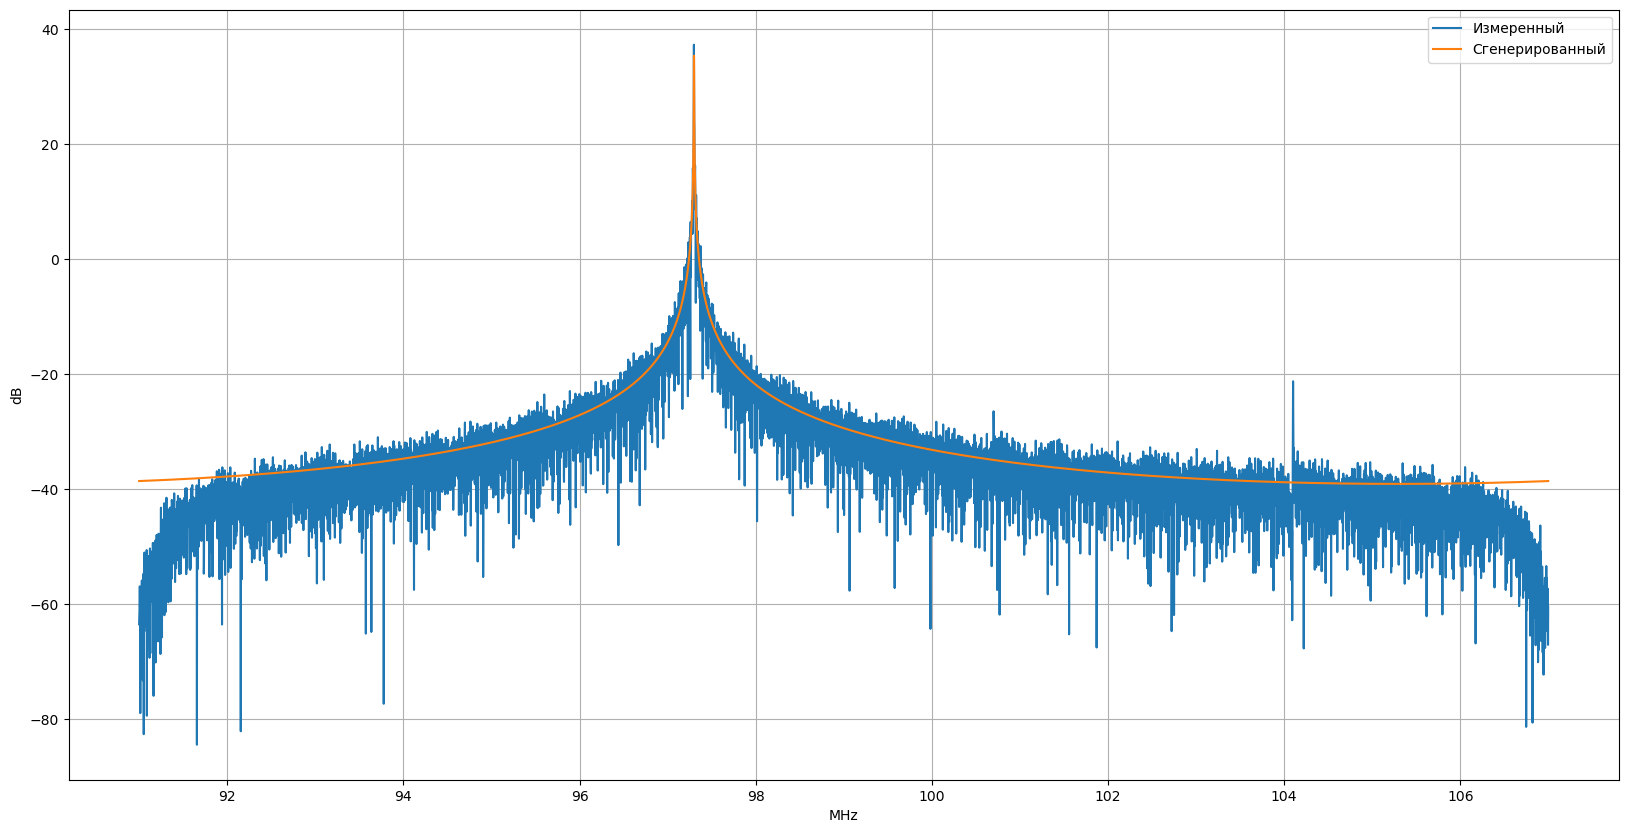

In [25]:
plt.figure(figsize=[20,10])
plt.plot(10*np.log10(y_measured_spectrum_norm), label="Измеренный")
plt.plot(10*np.log10(y_generated_spectrum_norm), label="Сгенерированный")
# plt.yscale('log')
plt.grid()
plt.xlabel("MHz")
plt.legend()
plt.ylabel("dB")
plt.show()

In [26]:
# Y
input_array = np.array([1,0,0,0,0])
output_array = np.array([0,0,0,0,1])
coord = 4
direction = False
x_signal, y_signal = generate_signal_bundle(direction, coord, input_array, output_array)

In [27]:
N = sdr.tx_buffer_size
sample_rate = sdr.sample_rate
times = np.linspace(0, N / sample_rate, N)
x_dots = x_signal(times)
y_dots = y_signal(times)

In [28]:
sdr.tx_destroy_buffer()
sdr.tx([x_dots, y_dots])

In [29]:
x_measured_spectrum, y_measured_spectrum = get_averaged_spectrum(sdr, 10)

In [30]:
x_generated_spectrum_ = fft.fftshift(fft.fft(x_dots))
y_generated_spectrum_ = fft.fftshift(fft.fft(y_dots))
frequencies = fft.fftshift(fft.fftfreq(x_dots.shape[0], 1 / sdr.sample_rate) + sdr.rx_lo) / 1e6
x_generated_spectrum = DataFrame(data = x_generated_spectrum_.imag**2 + x_generated_spectrum_.real**2, index = frequencies)
y_generated_spectrum = DataFrame(data = y_generated_spectrum_.imag**2 + y_generated_spectrum_.real**2, index = frequencies)
# generated_spectrum = generated_spectrum / generated_spectrum.max()

In [31]:
x_measured_spectrum_norm = x_measured_spectrum / x_measured_spectrum.mean()
y_measured_spectrum_norm = y_measured_spectrum / y_measured_spectrum.mean()
x_generated_spectrum_norm = x_generated_spectrum / x_generated_spectrum.mean()
y_generated_spectrum_norm = y_generated_spectrum / y_generated_spectrum.mean()

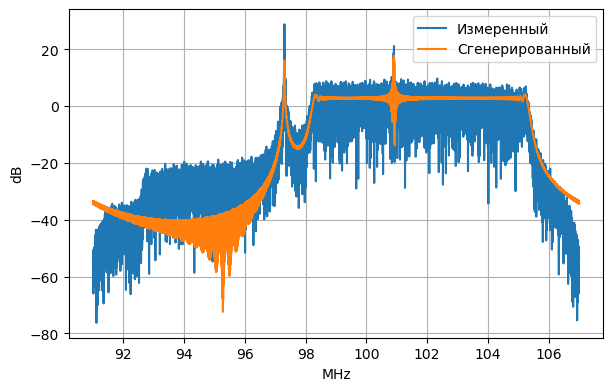

In [32]:
plt.figure(figsize=[width,height])
plt.plot(10*np.log10(y_measured_spectrum_norm), label="Измеренный")
plt.plot(10*np.log10(y_generated_spectrum_norm), label="Сгенерированный")
# plt.yscale('log')
plt.grid()
plt.xlabel("MHz")
plt.ylabel("dB")
plt.legend()
# plt.ylabel("dB")
# plt.savefig('../TeX/figures/spectrum/Y_measured_norm.pdf', bbox_inches='tight')
plt.show()

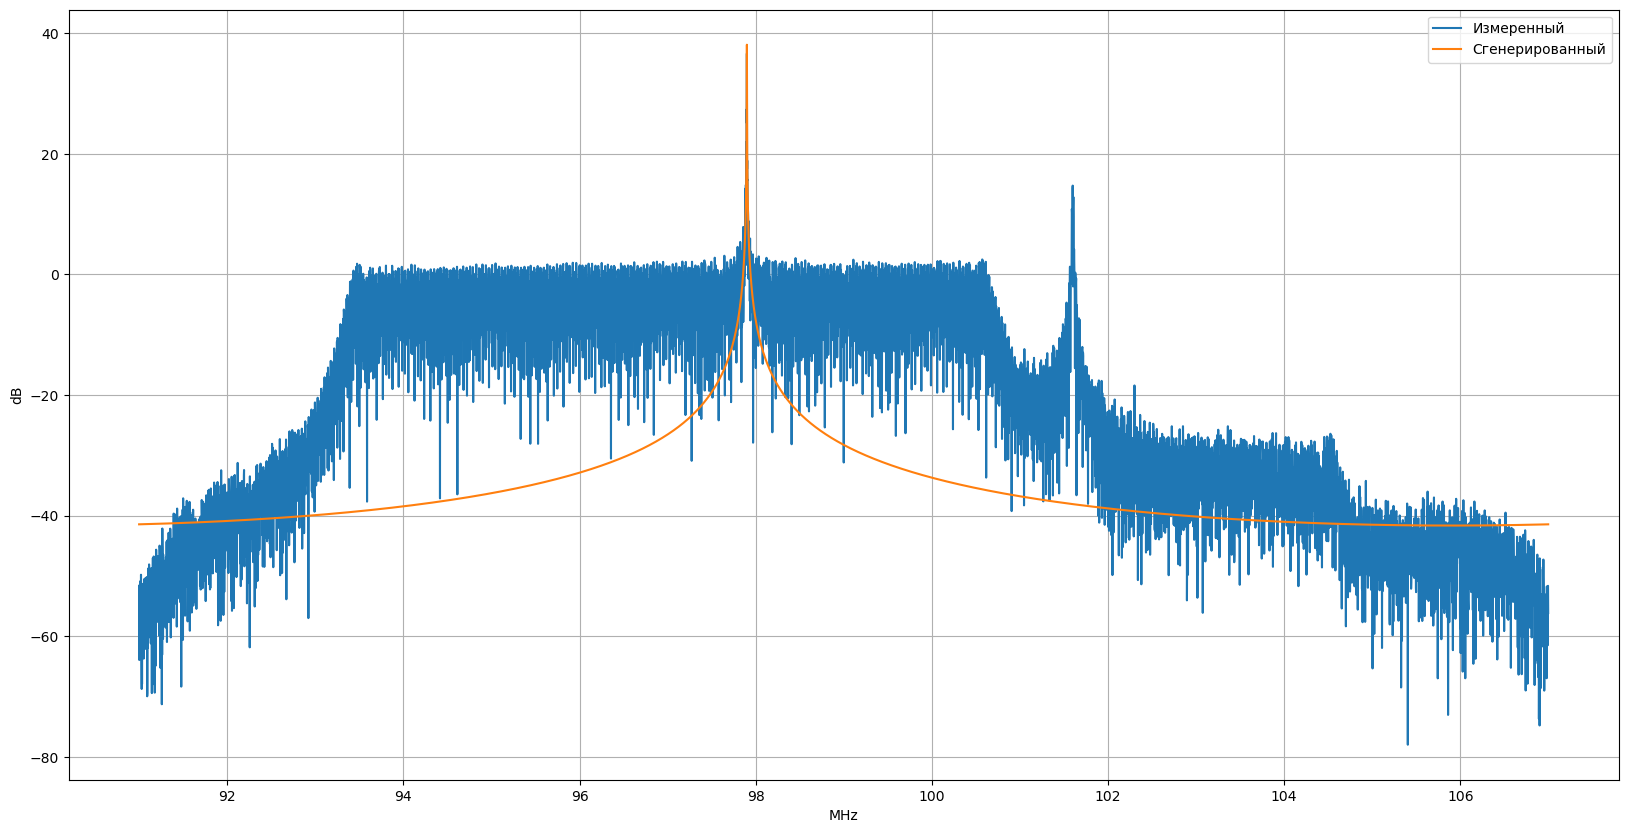

In [33]:
plt.figure(figsize=[20,10])
plt.plot(10*np.log10(x_measured_spectrum_norm), label="Измеренный")
plt.plot(10*np.log10(x_generated_spectrum_norm), label="Сгенерированный")
# plt.yscale('log')
plt.grid()
plt.xlabel("MHz")
plt.legend()
plt.ylabel("dB")
plt.show()

In [34]:
input_array = np.array([0,0,0,1,0])
output_array = np.array([0,1,0,0,0])
coord = 2
direction = True
x_signal, y_signal = generate_signal_bundle(direction, coord, input_array, output_array)

In [35]:
N = sdr.tx_buffer_size
sample_rate = sdr.sample_rate
times = np.linspace(0, N / sample_rate, N)
x_dots = x_signal(times)
y_dots = y_signal(times)

In [36]:
sdr.tx_destroy_buffer()
sdr.tx([x_dots, y_dots])

In [37]:
x_measured_spectrum, y_measured_spectrum = get_averaged_spectrum(sdr, 100)

In [38]:
x_generated_spectrum = fft.fftshift(fft.fft(x_dots))
y_generated_spectrum = fft.fftshift(fft.fft(y_dots))
frequencies = fft.fftshift(fft.fftfreq(x_dots.shape[0], 1 / sdr.sample_rate) + sdr.rx_lo) / 1e6
x_generated_spectrum = DataFrame(data = x_generated_spectrum.imag**2 + x_generated_spectrum.real**2, index = frequencies)
y_generated_spectrum = DataFrame(data = y_generated_spectrum.imag**2 + y_generated_spectrum.real**2, index = frequencies)
# generated_spectrum = generated_spectrum / generated_spectrum.max()

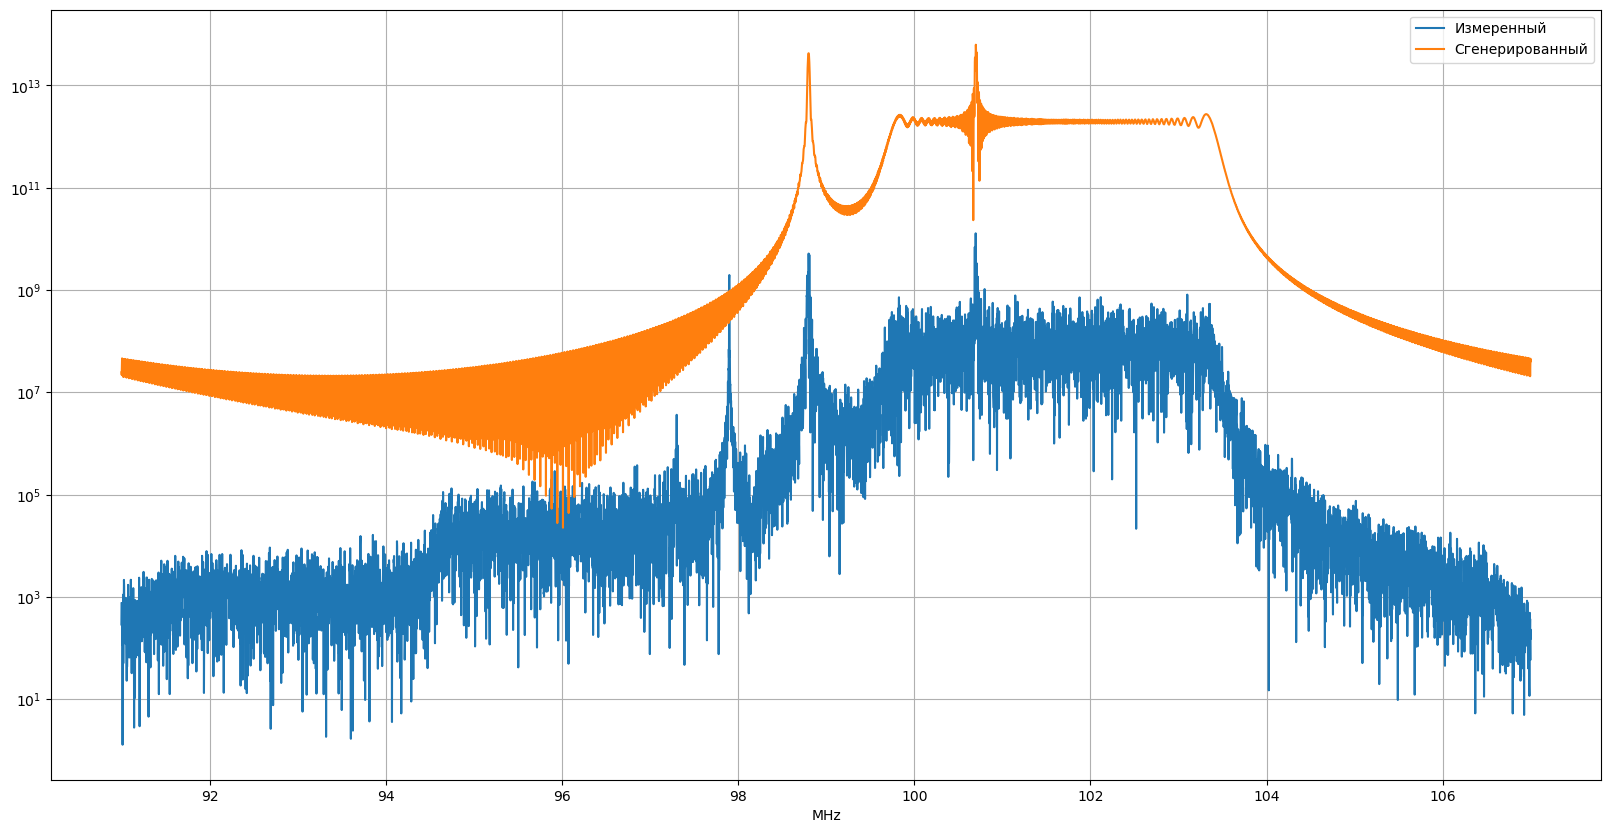

In [39]:
plt.figure(figsize=[20,10])
plt.plot(x_measured_spectrum, label="Измеренный")
plt.plot(x_generated_spectrum, label="Сгенерированный")
plt.yscale('log')
plt.grid()
plt.xlabel("MHz")
plt.legend()
# plt.ylabel("dB")
plt.show()

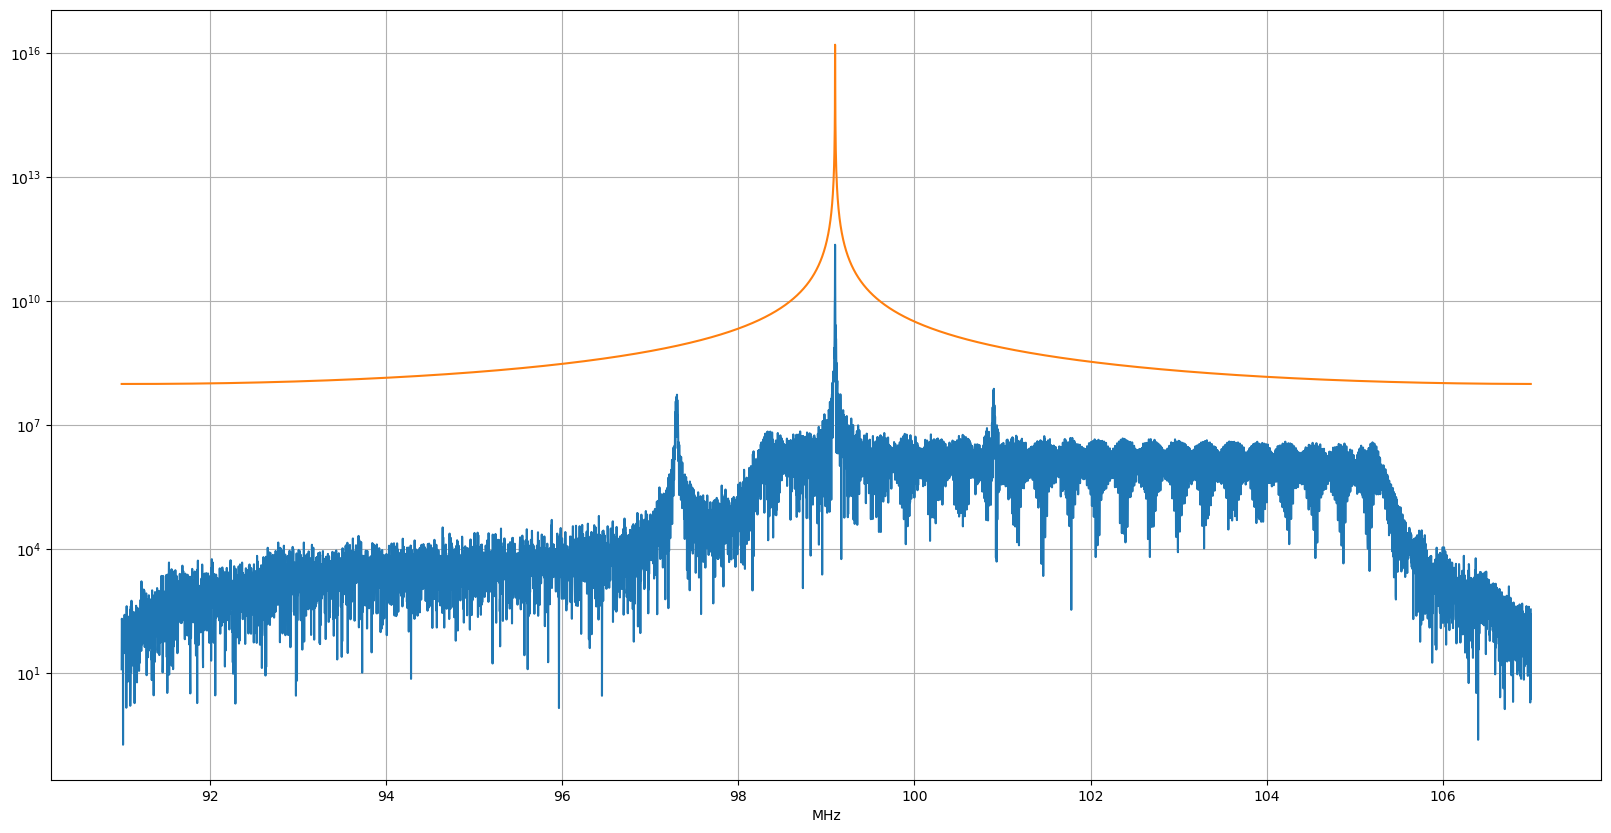

In [40]:
plt.figure(figsize=[20,10])
plt.plot(y_measured_spectrum)
plt.plot(y_generated_spectrum)
plt.yscale('log')
plt.grid()
plt.xlabel("MHz")
# plt.ylabel("dB")
plt.show()

In [41]:
print("Values:")
blacklist = ["gain_table_config", "multichip_sync"]
channel_blacklist = ["fastlock_recall","samples_pps"]
for dev in sdr.ctx.devices:
    print(dev.name, "{")
    if dev.name == "ams" or dev.name == "ad7291" or dev.name == None:
        continue
    for attr in dev.attrs:
        attr = dev.attrs[attr]
        print("\t",attr.name,end=" ")
        if attr.name in blacklist:
            print()
        else:
            print(attr.value)
    print("Channel attrs:")
    for channel in dev.channels:
        print("\t",channel.name, "{")
        for attr in channel.attrs:
            attr = channel.attrs[attr]
            print("\t\t",attr.name,end=" ")
            if attr.name in channel_blacklist:
                print()
            else:
                print(attr.value)
        print("\t}")
    print("}")

Values:
ams {
ad9361-phy {
	 calib_mode auto
	 calib_mode_available auto manual manual_tx_quad tx_quad rf_dc_offs rssi_gain_step
	 dcxo_tune_coarse 8
	 dcxo_tune_coarse_available [0 1 63]
	 dcxo_tune_fine 5920
	 dcxo_tune_fine_available [0 1 8191]
	 ensm_mode fdd
	 ensm_mode_available sleep wait alert fdd pinctrl pinctrl_fdd_indep
	 filter_fir_config FIR Rx: 128,4 Tx: 128,4
	 gain_table_config 
	 multichip_sync 
	 rssi_gain_step_error lna_error: 0 0 0 0
mixer_error: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
gain_step_calib_reg_val: 0 0 0 0 0
	 rx_path_rates BBPLL:1024000000 ADC:512000000 R2:256000000 R1:128000000 RF:64000000 RXSAMP:16000000
	 trx_rate_governor nominal
	 trx_rate_governor_available nominal highest_osr
	 tx_path_rates BBPLL:1024000000 DAC:256000000 T2:128000000 T1:64000000 TF:64000000 TXSAMP:16000000
	 xo_correction 40000000
	 xo_correction_available [40000000 1 40000000]
Channel attrs:
	 RX_LO {
		 external 0
		 fastlock_load 0
		 fastlock_recall 
		 fastlock_save 0 141,141,141,1

In [42]:
# X
input_array = np.array([1,1,0,0,0])
output_array = np.array([0,0,1,0,1])
coord = 2
direction = True
time = transition_time(coord_to_freq(start, direction), coord_to_freq(stop, direction))*0.45
x_signal, y_signal = generate_picture_bundle(direction, coord, input_array, output_array, time)

N = sdr.tx_buffer_size
sample_rate = sdr.sample_rate
times = np.linspace(0, N / sample_rate, N)
x_dots = x_signal(times)
y_dots = y_signal(times)

sdr.tx_destroy_buffer()
sdr.tx([x_dots, y_dots])

# Выключение

In [43]:
sdr.tx_destroy_buffer()